# Predicting the Status of Tanzanian Wells

## Background 

In many parts of Tanzania, women are responsible for the collection and provision of water for their households. Water sources are often far from their homes, so water collection is labor intensive and time consuming. The responsibility also often falls on girls or younger women who often have to compromise their education to get clean water. 

Additionally, the quality of the available drinking water is often of a poor standard and can be unsafe to drink. The quantity of water in some villages is also very seasonally dependent with insufficient availability for much of the year.

## Why model water pumps in Tanzania? 
Many non profit and government organizations have sought to address these issues by constructing water pumps around Tanzania, but there have been fewer efforts to maintain the pumps or see if they are still working.  In an effort to use data to inform water policy, The Tanzanian government partnered with DrivenData to create a data science challenge to better identify important predictors of a functional well. The Tanzanian Ministry of Water will use the results from the challenge to classify wells into the following three categories: "functional", "non-functional", and "needs repair".

## Data Set
The data set was provided by DrivenData. The data was collected by the Taarifa non-profit and the Tanzanian Ministry of Water. It contains information covering around 30 features and 60,000 wells. 

Assumptions about the data include the assumption that the data was collected properly and uniformly in a way that did not introduce bias into the data set.  Also the assumption that the data is accurate.

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.feature_selection import SelectKBest
%matplotlib inline
from sklearn.linear_model import Lasso, LogisticRegression, ElasticNet
import missingno as msno
import time 
from sklearn import metrics
import matplotlib.cm as cmx
import matplotlib.colors as colors
import sklearn.cluster as cluster
from sklearn.cluster import DBSCAN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn import linear_model, svm
from sklearn.model_selection import cross_val_score,KFold
from sklearn.pipeline import FeatureUnion, Pipeline, make_union, make_pipeline
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from mpl_toolkits.basemap import Basemap
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

Using TensorFlow backend.


### Load Data
Here I loaded data from the DrivenData competition page:
https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/

In [2]:
X_train = pd.read_csv('CapstoneX_train.csv')
y_train = pd.read_csv('CapstoneY_train.csv')
X_test = pd.read_csv('CapstoneY_test.csv')


### Map of Wells
I wanted to visually see where the water pumps were in Tanzania

In [3]:
# adapted from http://matplotlib.org/basemap/users/examples.html

def wellmap(X_train, category, use_colors = False, cmap = False, ax = False, lat_0=-6,lon_0=34,llcrnrlon=28, llcrnrlat=-12,
                urcrnrlon=41, urcrnrlat=0):
    

    m = Basemap(projection='cyl',
                resolution='h',
                lat_0=lat_0,lon_0=lon_0, 
                llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
                urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat, 
                ax=ax)

    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    m.fillcontinents(color='white',lake_color='aqua', zorder = 0)

    if use_colors:
        m.scatter(X_train.longitude.values, X_train.latitude.values, marker = 'o',zorder = 1, latlon=True, alpha = 0.05, 
                  c=[use_colors[x] for x in category],s=30,lw=0)


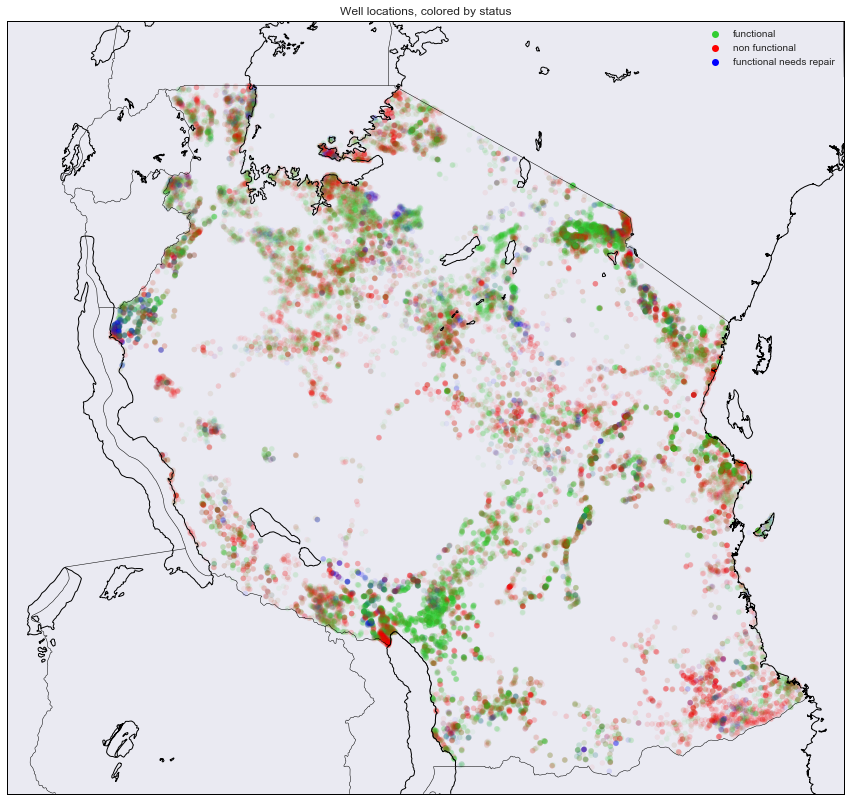

In [5]:

fig, (ax1) = plt.subplots( figsize=(15, 15))
# status map
use_colors = {"functional": "limegreen", "non functional": "red", "functional needs repair": "blue"}
wellmap(X_train, y_train.status_group, use_colors = use_colors, ax = ax1)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in use_colors.values()]
ax1.legend(markers, use_colors.keys(), numpoints=1)
ax1.set_title("Well locations, colored by status")



### Look at size of dataframe

In [6]:
X_train.shape

(59400, 40)

In [7]:
y_train.shape

(59400, 2)

In [8]:
X_test.shape

(14850, 40)

### Inspecting target variable:

In [9]:
y_train.head(2)

,id,status_group
0,69572,functional
1,8776,functional


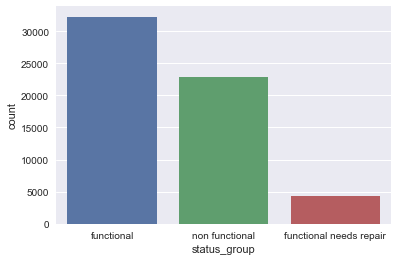

In [10]:
#Looking at target variable. It's imbalanced
sns.countplot(y_train['status_group'])

### Looking at X_train columns, considering potential features

In [11]:
for i in X_train.columns:
    print (i,',' ,'{:.1%}'.format(np.mean(X_train[i].isnull())),'nulls',',',type(X_train[i][0]), X_train[i].nunique(), 'unique values')


id , 0.0% nulls , <class 'numpy.int64'> 59400 unique values
amount_tsh , 0.0% nulls , <class 'numpy.float64'> 98 unique values
date_recorded , 0.0% nulls , <class 'str'> 356 unique values
funder , 6.1% nulls , <class 'str'> 1897 unique values
gps_height , 0.0% nulls , <class 'numpy.int64'> 2428 unique values
installer , 6.2% nulls , <class 'str'> 2145 unique values
longitude , 0.0% nulls , <class 'numpy.float64'> 57516 unique values
latitude , 0.0% nulls , <class 'numpy.float64'> 57517 unique values
wpt_name , 0.0% nulls , <class 'str'> 37400 unique values
num_private , 0.0% nulls , <class 'numpy.int64'> 65 unique values
basin , 0.0% nulls , <class 'str'> 9 unique values
subvillage , 0.6% nulls , <class 'str'> 19287 unique values
region , 0.0% nulls , <class 'str'> 21 unique values
region_code , 0.0% nulls , <class 'numpy.int64'> 27 unique values
district_code , 0.0% nulls , <class 'numpy.int64'> 20 unique values
lga , 0.0% nulls , <class 'str'> 125 unique values
ward , 0.0% nulls , <c

In [12]:
X_train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


### Look at Null Values

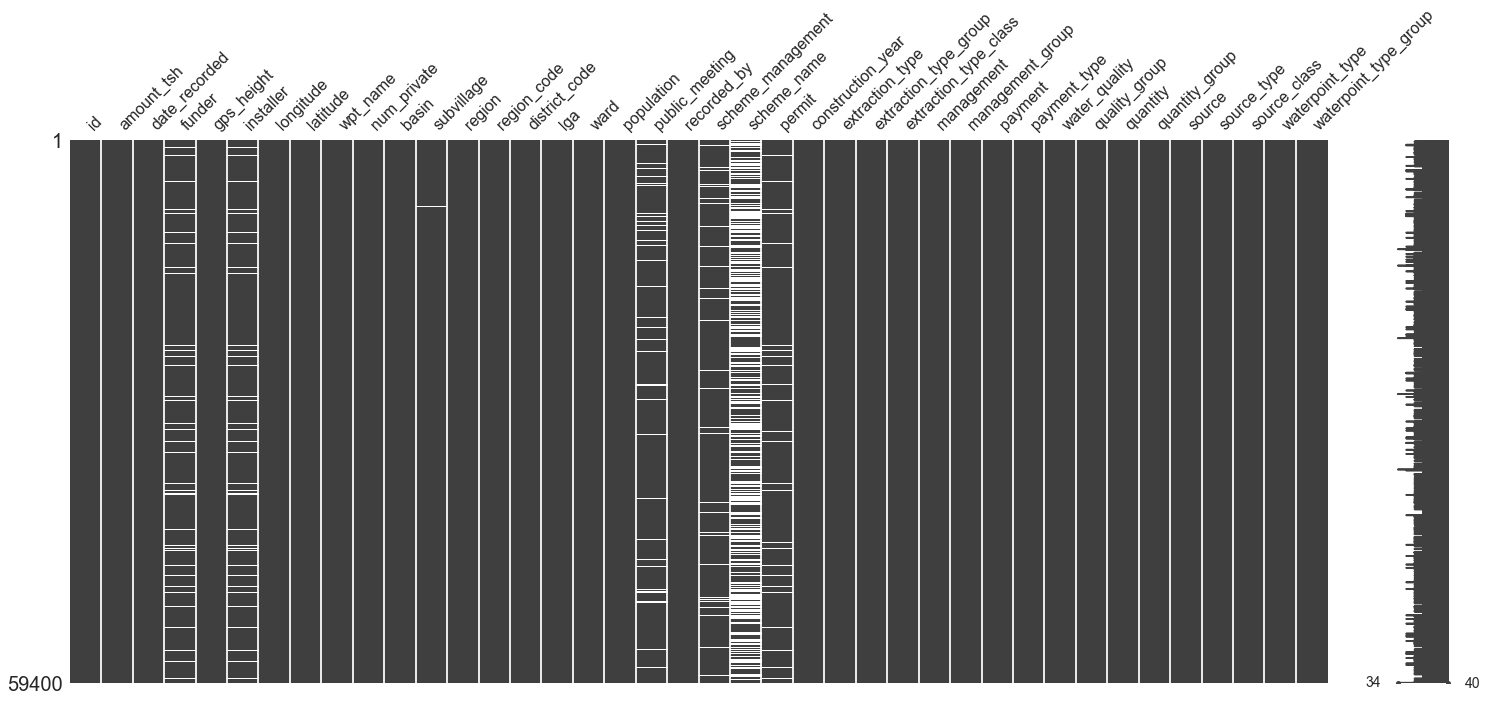

In [13]:
msno.matrix(X_train)

### Variables to Initially Drop:

In [14]:
# id: Doesn't have predictive value
#'amount_tsh': Mostly empty
# wpt_name: Likely no predictive value
# scheme_name: Likely no predictive value and nearly half is null
# num_private:  nearly all values are zeros.

X_train= X_train.drop(['id', 'amount_tsh', 'wpt_name', 'scheme_name', 'num_private', 'subvillage'], axis=1)

In [15]:
X_test= X_test.drop(['id', 'amount_tsh', 'wpt_name', 'scheme_name', 'num_private', 'subvillage'], axis=1)

In [16]:
y_train = y_train.drop('id', axis =1)

#### Impute Values

In [17]:
imp=Imputer(missing_values=0, strategy="mean" )
X_train["construction_year"]=imp.fit_transform(X_train[["construction_year"]])

In [18]:
X_test["construction_year"]=imp.fit_transform(X_test[["construction_year"]])

In [ ]:
X_train.shape

In [ ]:
X_test.shape

#### Fill Remaining Nulls

In [19]:
X_train=X_train.fillna('Unknown')

In [20]:
X_test=X_test.fillna('Unknown')

### Cluster based on geographic location

In [21]:
df= X_train[['latitude', 'longitude']].copy()

In [23]:
dftest= X_test[['latitude', 'longitude']].copy()

In [24]:
db = DBSCAN(eps=.25, min_samples=5).fit(np.radians(df))
db.fit(df)


DBSCAN(algorithm='auto', eps=0.25, leaf_size=30, metric='euclidean',
    min_samples=5, n_jobs=1, p=None)

In [25]:
core_samples = db.core_sample_indices_
labels = db.labels_

In [26]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

In [27]:
df['cluster'] = labels


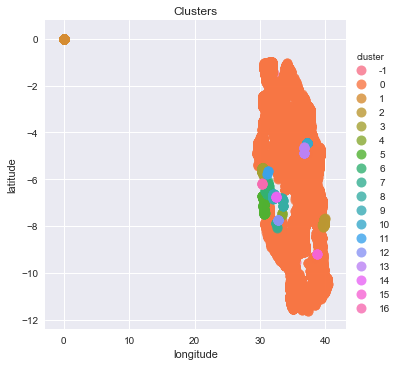

In [28]:
sns.lmplot('longitude', # Horizontal axis
           'latitude', # Vertical axis
           data=df, # Data source
           fit_reg=False, # Don't fix a regression line
           hue="cluster", # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size

# Set title
plt.title('Clusters')

# Set x-axis label
plt.xlabel('longitude')

# Set y-axis label
plt.ylabel('latitude')


In [29]:
df.cluster.value_counts()


 0     56641
 1      1812
 6       278
 3       203
 5       134
 2       132
 9        75
 10       30
 8        22
 13       16
 12       12
 7         8
 14        8
-1         8
 16        6
 11        5
 4         5
 15        5
Name: cluster, dtype: int64

In [30]:
df.shape

(59400, 3)

In [33]:
df.head(2)

,latitude,longitude,cluster
0,-9.856322,34.938093,0
1,-2.147466,34.698766,0


In [34]:
db2 = DBSCAN(eps=.25, min_samples=5).fit(np.radians(dftest))
db2.fit(dftest)

DBSCAN(algorithm='auto', eps=0.25, leaf_size=30, metric='euclidean',
    min_samples=5, n_jobs=1, p=None)

In [35]:
core_samples2 = db2.core_sample_indices_
labels2 = db2.labels_

In [36]:
set(labels2)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

In [37]:
dftest['cluster'] = labels2

In [38]:
dftest.head(3)

,latitude,longitude,cluster
0,-4.059696,35.290799,0
1,-3.309214,36.656709,0
2,-5.004344,34.767863,0


In [39]:
X_train = pd.concat([X_train, df['cluster']], axis=1)

In [40]:
X_test = pd.concat([X_test, dftest['cluster']], axis=1)

In [41]:
X_train.shape

(59400, 35)

In [42]:
X_test.shape

(14850, 35)

### Heatmap of Numerical Features 

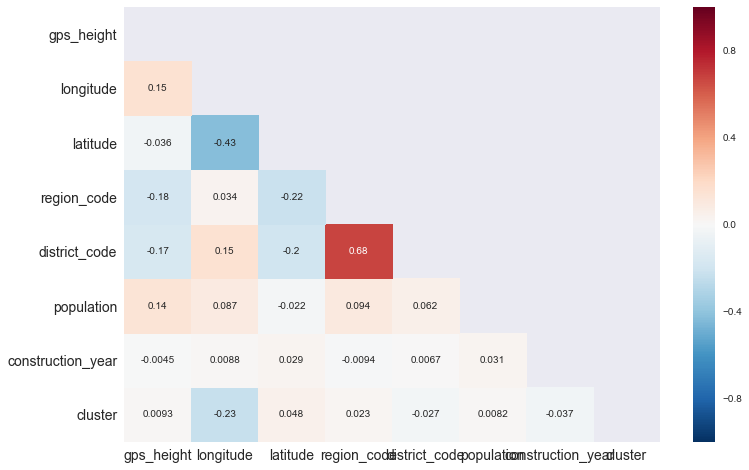

In [43]:

X_train_corr = X_train.corr()
fix, ax = plt.subplots(figsize=(12,8))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(X_train_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(X_train_corr, mask=mask, ax=ax, annot=True)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)
plt.show()

### Adjusting Categorical Variables

In [44]:
X_train.dtypes

date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
basin                     object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
permit                    object
construction_year        float64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_quality             object
quality_group             object
quantity                  object
quantity_group            object
source                    object
source_typ

In [45]:
X_train.nunique()

date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
basin                        9
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               3
recorded_by                  1
scheme_management           13
permit                       3
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoi

In [46]:
X_test.nunique()

date_recorded              331
funder                     980
gps_height                2157
installer                 1091
longitude                14390
latitude                 14390
basin                        9
region                      21
region_code                 26
district_code               20
lga                        125
ward                      1959
population                 637
public_meeting               3
recorded_by                  1
scheme_management           12
permit                       3
construction_year           55
extraction_type             17
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoi

In [47]:
X_train=pd.get_dummies(X_train)

In [48]:
X_test=pd.get_dummies(X_test)

In [49]:
traingetridof= list(set(X_train.columns)-set(X_test.columns))

In [50]:
traingetridof

['funder_Bukwang Church Saint',
 'installer_NAFCO',
 'installer_Said Hashim',
 'installer_Jumuhia',
 'installer_UN Habitat',
 'funder_Nyabarongo Kegoro',
 'funder_Msikitini',
 'installer_RO',
 'funder_Pag Church',
 'funder_Community Bank',
 'installer_DODDEA',
 'installer_Team Rafiki',
 'funder_Suasa',
 'installer_Water  Aid/Maji tech',
 'installer_Te',
 'installer_Jumuiya',
 'funder_Robert Kampala',
 'funder_Bahresa',
 'funder_Balo',
 'installer_MASWI DRILL',
 'date_recorded_2004-08-01',
 'installer_F',
 'funder_Village Communi',
 'funder_Norad/rudep',
 'funder_Irish Government',
 'installer_VICKFI',
 'funder_Kalitesi',
 'installer_Kahema',
 'funder_Nyeisa',
 'installer_RUVUMA BASIN',
 'funder_Dsdp',
 'installer_WBK',
 'funder_Babtest',
 'installer_Msig',
 'funder_Tgt',
 'funder_Banca Reale',
 'installer_Yasini',
 'installer_SONGAS',
 'installer_UNICRF',
 'installer_Alex moyela',
 'funder_Dominiki Simwen',
 'funder_Issa Mohamedi Tumwanga',
 'funder_Madaraweshi',
 'funder_Natherland',


In [51]:
os = [0 for i in range(14850)]

In [52]:
my_dict = {}
for i in traingetridof:
    my_dict[i]=os

In [53]:
addtotest=pd.DataFrame(my_dict)

In [54]:
addtotest.shape

(14850, 2658)

In [55]:
X_train.shape

(59400, 6799)

In [56]:
os2 = [0 for i in range(59400)]

In [57]:
testgetridof= list(set(X_test.columns)-set(X_train.columns))

In [58]:
my_dict2 = {}
for i in testgetridof:
    my_dict2[i]=os2

In [60]:
addtotrain=pd.DataFrame(my_dict2)

In [61]:
addtotrain.shape

(59400, 527)

In [62]:
X_test = pd.concat([X_test, addtotest], axis=1)

In [63]:
X_train = pd.concat([X_train, addtotrain], axis =1)

In [64]:
X_test.shape

(14850, 7326)

In [65]:
X_train.shape

(59400, 7326)

In [66]:
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train,y_train)

In [67]:
def pumpcategory(cell):
    if cell == 'functional':
        return 3
    elif cell == 'non functional': 
        return 2
    elif cell == 'functional needs repair':
        return 1
    else:
        pass

In [68]:
y_train_test['status_group']=y_train_test['status_group'].map(pumpcategory)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [69]:
y_train_train['status_group']=y_train_train['status_group'].map(pumpcategory)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [71]:
X_train.shape

(59400, 7326)

In [72]:
X_test.shape

(14850, 7326)

In [74]:
X_train.to_csv('Capstone_X_train2.csv')

In [75]:
X_test.to_csv('Capstone_X_test2.csv')

### Calculate Baseline

In [73]:
y_train_test.status_group.value_counts() / len(y_train_test)

3    0.542088
2    0.385791
1    0.072121
Name: status_group, dtype: float64

In [ ]:
y_train_test.status_group.value_counts() / len(y_train_test)

### Models

In [ ]:
X_train = pd.read_csv('Capstone_X_train.csv')
y_train = pd.read_csv('CapstoneY_train.csv')
X_test = pd.read_csv('Capstone_X_test.csv')

In [79]:
#Model#1 Random Forest Classifier
rfc=RandomForestClassifier()

In [80]:
rfc.fit(X_train_train,y_train_train)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [81]:
rfc_preds = rfc.predict(X_train_test)

In [83]:
confusion_matrix(y_train_test,rfc_preds)

array([[ 417,  184,  470],
       [ 146, 4540, 1043],
       [ 336,  959, 6755]])

In [85]:
print(classification_report(y_train_test,rfc_preds))

             precision    recall  f1-score   support

          1       0.46      0.39      0.42      1071
          2       0.80      0.79      0.80      5729
          3       0.82      0.84      0.83      8050

avg / total       0.78      0.79      0.79     14850



In [82]:
rfc.score(X_train_test,y_train_test)

0.78868686868686866

In [86]:
rfc.feature_importances_

array([ 0.04337582,  0.08128615,  0.08295335, ...,  0.        ,
        0.        ,  0.        ])

In [88]:
feature_importances=pd.DataFrame(columns=['feature','importance'])

In [90]:
feature_importances['feature']= X_train.columns

In [92]:
feature_importances['importance']=rfc.feature_importances_

In [94]:
feature_importances= feature_importances.set_index('feature')

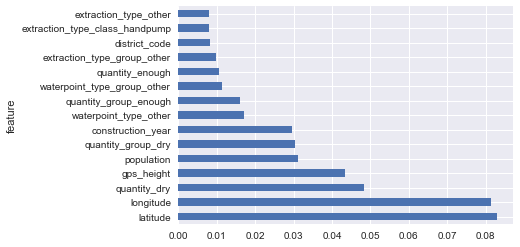

In [96]:
feature_importances['importance'].sort_values(ascending = False).head(15).plot(kind='barh');

## Models

In [97]:
#Model 2: GradientBoosting Classifier 
scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=35))
gbr = ('gbr',(GradientBoostingClassifier(learning_rate=0.1, verbose=1, max_depth=3, max_features=None, max_leaf_nodes=None, n_estimators=75)))
pipe=Pipeline([scaling, pca, gbr])

pipe.fit(X_train_train, y_train_train)
preds = pipe.predict(X_train_test)
print (pipe.score(X_train_test,y_train_test))
print (confusion_matrix(y_train_test, preds))
print(classification_report(y_train_test,preds))


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1       43035.2293            1.39m
         2       41688.0604            1.26m
         3       40565.2996            1.17m
         4       39561.9812            1.10m
         5       38723.7748            1.11m
         6       37976.0646            1.13m
         7       37333.4625            1.16m
         8       36780.6551            1.14m
         9       36279.8097            1.13m
        10       35802.0700            1.11m
        20       32907.7255           53.36s
        30       31501.5251           41.57s
        40       30633.9316           30.96s
        50       30028.7196           21.69s
        60       29529.3668           12.87s
        70       29109.6203            4.30s
0.71898989899
[[  90  192  789]
 [  21 3388 2320]
 [  42  809 7199]]
             precision    recall  f1-score   support

          1       0.59      0.08      0.15      1071
          2       0.77      0.59      0.67      5729
     

In [98]:
#Model 2: GradientBoosting Classifier w/o PCA
scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=35))
gbr = ('gbr',(GradientBoostingClassifier(learning_rate=0.1, verbose=1, max_depth=3, max_features=None, max_leaf_nodes=None, n_estimators=75)))
pipe=Pipeline([scaling, gbr])

pipe.fit(X_train_train, y_train_train)
preds = pipe.predict(X_train_test)
print (pipe.score(X_train_test,y_train_test))
print (confusion_matrix(y_train_test, preds))
print(classification_report(y_train_test,preds))

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1       42434.6402           81.26m
         2       40632.3130           71.63m
         3       39130.7920           73.81m
         4       37883.4262           75.73m
         5       36848.8587           70.18m
         6       35948.6359           65.65m
         7       35200.8780           62.49m
         8       34512.6416           60.63m
         9       33901.6056           64.04m
        10       33398.1770           62.65m
        20       30374.6020           55.84m
        30       29041.1404           46.45m
        40       28309.5189           35.05m
        50       27771.6626           24.70m
        60       27402.3883           14.13m
        70       27064.4352            4.47m
0.75367003367
[[ 174  127  770]
 [  34 3478 2217]
 [  48  462 7540]]
             precision    recall  f1-score   support

          1       0.68      0.16      0.26      1071
          2       0.86      0.61      0.71      5729
     

In [101]:
#Model 3: Random Forest Classifer w/AdaBoostClassifier
scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=35))
rfc = ('rfc',AdaBoostClassifier(RandomForestClassifier(verbose=1)))
pipe=Pipeline([scaling, rfc])

pipe.fit(X_train_train, y_train_train)
preds = pipe.predict(X_train_test)
print (pipe.score(X_train_test,y_train_test))
print (confusion_matrix(y_train_test, preds))
print(classification_report(y_train_test,preds))


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   33.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  1

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]

0.790505050505
[[ 429  167  475]
 [ 148 4466 1115]
 [ 359  847 6844]]
             precision    recall  f1-score   support

          1       0.46      0.40      0.43      1071
          2       0.81      0.78      0.80      5729
          3       0.81      0.85      0.83      8050

avg / total       0.79      0.79      0.79     14850



In [100]:
#Model 4: Random Forest Classifer w/AdaBoostClassifier w/o PCA
scaling = ('scaling', StandardScaler())
rfc = ('rfc',AdaBoostClassifier(RandomForestClassifier()))
pipe=Pipeline([scaling, rfc])

pipe.fit(X_train_train, y_train_train)
preds = pipe.predict(X_train_test)
print (pipe.score(X_train_test,y_train_test))
print (confusion_matrix(y_train_test, preds))
print(classification_report(y_train_test,preds))


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.790841750842
[[ 423  165  483]
 [ 141 4463 1125]
 [ 340  852 6858]]
             precision    recall  f1-score   support

          1       0.47      0.39      0.43      1071
          2       0.81      0.78      0.80      5729
          3       0.81      0.85      0.83      8050

avg / total       0.79      0.79      0.79     14850



In [103]:
#Model 5: Random Forest Classifier (scaled and with PCA) w/o AdaBoostClassifier
scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=35))
rfc = ('rfc',(RandomForestClassifier(verbose=1)))
pipe=Pipeline([scaling, pca, rfc])

pipe.fit(X_train_train, y_train_train)
preds = pipe.predict(X_train_test)
print (pipe.score(X_train_test,y_train_test))
print (confusion_matrix(y_train_test, preds))
print(classification_report(y_train_test,preds))

/anaconda/lib/python3.6/site-packages/sklearn/pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


0.759057239057
[[ 353  248  470]
 [ 139 4455 1135]
 [ 315 1271 6464]]
             precision    recall  f1-score   support

          1       0.44      0.33      0.38      1071
          2       0.75      0.78      0.76      5729
          3       0.80      0.80      0.80      8050

avg / total       0.75      0.76      0.76     14850



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [102]:
#Model 6: Decision Tree Classifier
scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=35))
dtc = ('dtc',(DecisionTreeClassifier()))
pipe=Pipeline([scaling, pca, dtc])

pipe.fit(X_train_train, y_train_train)
preds = pipe.predict(X_train_test)
print (pipe.score(X_train_test,y_train_test))
print (confusion_matrix(y_train_test, preds))
print(classification_report(y_train_test,preds))

0.686464646465
[[ 397  257  417]
 [ 331 4055 1343]
 [ 675 1633 5742]]
             precision    recall  f1-score   support

          1       0.28      0.37      0.32      1071
          2       0.68      0.71      0.69      5729
          3       0.77      0.71      0.74      8050

avg / total       0.70      0.69      0.69     14850



In [104]:
#Model 7: SVM
scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=35))
svm = ('svm',(LinearSVC()))
pipe=Pipeline([scaling, pca, svm])

pipe.fit(X_train_train, y_train_train)
preds = pipe.predict(X_train_test)
print (pipe.score(X_train_test,y_train_test))
print (confusion_matrix(y_train_test, preds))
print(classification_report(y_train_test,preds))

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.677373737374
[[   0  217  854]
 [   0 3096 2633]
 [   0 1087 6963]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00      1071
          2       0.70      0.54      0.61      5729
          3       0.67      0.86      0.75      8050

avg / total       0.63      0.68      0.64     14850



/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [105]:
#Model 8: K Nearest Neighbors
scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=35))
knn = ('knn',(KNeighborsClassifier()))
pipe=Pipeline([scaling, pca, knn])

pipe.fit(X_train_train, y_train_train)
preds = pipe.predict(X_train_test)
print (pipe.score(X_train_test,y_train_test))
print (confusion_matrix(y_train_test, preds))
print(classification_report(y_train_test,preds))

/anaconda/lib/python3.6/site-packages/sklearn/pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.762760942761
[[ 385  214  472]
 [ 200 4298 1231]
 [ 330 1076 6644]]
             precision    recall  f1-score   support

          1       0.42      0.36      0.39      1071
          2       0.77      0.75      0.76      5729
          3       0.80      0.83      0.81      8050

avg / total       0.76      0.76      0.76     14850



In [ ]:
#Model 8: K Nearest Neighbors w/o PCA
scaling = ('scaling', StandardScaler())
knn = ('knn',(KNeighborsClassifier()))
pipe=Pipeline([scaling, knn])

pipe.fit(X_train_train, y_train_train)
preds = pipe.predict(X_train_test)
print (pipe.score(X_train_test,y_train_test))
print (confusion_matrix(y_train_test, preds))
print(classification_report(y_train_test,preds))

/anaconda/lib/python3.6/site-packages/sklearn/pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [ ]:
#Model 9: Logisitic Regression w/AdaBoostClassifier
scaling = ('scaling', StandardScaler())
pca = ('pca', PCA(n_components=35))
log = ('log',AdaBoostClassifier(LogisticRegressionCV()))
pipe=Pipeline([scaling, pca, log])

pipe.fit(X_train_train, y_train_train)
preds = pipe.predict(X_train_test)
print (pipe.score(X_train_test,y_train_test))
print (confusion_matrix(y_train_test, preds))
print(classification_report(y_train_test,preds))

In [ ]:
y_train_train= to_categorical(y_train_train)

In [ ]:
y_train_test = to_categorical(y_train_test)


In [ ]:
#Model 5: Neural Network
model = Sequential()
model.add(Dense(10,input_dim=X_train_train.shape[1],activation='relu'))
model.add(Dropout(.5))
model.add(Dense(5, activation='relu'))
model.add(Dense(y_train_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_train, y_train_train, validation_data=(X_train_test, y_train_test), epochs=20, batch_size=70)